# Use `ScenarioSeries` to check goodness of fit for a series of simulations

The `prms_python` module provides the `ScenarioSeries` class to set up and run a number of simulations at once in parallel with a common purpose. One example would be to do some sensitivity analyses of a set of parameters. We'll show this application below.

## scale snow_adj and rad_trncf by multiplicative factors

The example we'll show modifies `jh_coef` and `rad_trncf` by scaling them. 

In [1]:
import sys
sys.path.append('..')
from prms_python import ScenarioSeries

In [2]:
base_dir = '../models/lbcd/'
simulation_dir = 'jupyternb-scenario-series-example/'
title = 'Jensen-Hays and radiative transfer function sensitivity analysis'
description = '''
Use title of \'"jh_coef":{jh factor value}|"rad_trncf":{rad factor value}\' so later
we can easily generate a dictionary of these factor value combinations.
'''

sc_series = ScenarioSeries(base_dir, simulation_dir, title, description)

At this point we have only initialized the series, but we have not created any new scenarios since we have not yet specified what functions will be applied for each of the scenarios. We'll do that next. We need to define a list of dictionaries, each containing the specification for a scenario. First we'll define a function with the signature `_scale_fun(val)` that will itself return a function with the signature `scale(x)` which scales `x` by `val`. This function will then be used to scale all the parameter values by the same amount, `val`.

In total we will generate sixteen scenarios, with a cartesian product of scaling factors ranging from 0.7 to 1.0. This takes a bit of time since we must copy rather large files, currently in series. We should probably change this to operate in parallel which would be safe since we only read from the same file, not write.

In [3]:
import numpy as np

def _scale_fun(val):
    def scale(x):
        return x*val
    
    return scale

scenario_list = [
    {
        'title': '"jh_coef":{0:.1f}|"rad_trncf":{1:.1f}'.format(jh_val, rad_val),
        'jh_coef': _scale_fun(jh_val),
        'rad_trncf': _scale_fun(rad_val)
    }
    for jh_val in np.arange(0.7, 1.0, 0.1)
    for rad_val in np.arange(0.7, 1.0, 0.1)
]

sc_series.build(scenario_list)

Now with the ScenarioSeries built, that is, the directory structure initialized and scenario data prepared, we can run the scenario series. The runner automatically uses half the available CPUs if the optional kwarg `nproc` is not provided.

In [4]:
sc_series.run()  # alternatively sc_series.run(nproc=10)

0
0
0
0
0000



0000



0000





## Analyze the data generated by ScenarioSeries

`ScenarioSeries` provides a mapping from UUID string-named directories to titles we used in `series_metadata.json`. Below is a printout of this `series_metadata.json`.

In [5]:
import json
metadata = json.loads(open('jupyternb-scenario-series-example/series_metadata.json').read())

print json.dumps(metadata, indent=2)

{
  "uuid_title_map": {
    "bceb006f-c395-4b5f-a0c2-4a9a79d98e56": "\"jh_coef\":0.7|\"rad_trncf\":1.0", 
    "258b275f-3f3a-4fa3-a836-7043332a0700": "\"jh_coef\":0.7|\"rad_trncf\":0.7", 
    "ba38e1a2-076b-45b7-9c5c-0fbda7482675": "\"jh_coef\":1.0|\"rad_trncf\":1.0", 
    "a002fd0e-7473-4d85-a80e-ec933020abe1": "\"jh_coef\":0.9|\"rad_trncf\":0.8", 
    "773b208d-526e-4184-94ce-d298a1c41023": "\"jh_coef\":0.7|\"rad_trncf\":0.8", 
    "3b21594a-6fbb-4cd9-9f72-3301c7319c44": "\"jh_coef\":0.9|\"rad_trncf\":0.9", 
    "245cf634-1a4a-481c-a1e5-9dbd067ecc9f": "\"jh_coef\":0.8|\"rad_trncf\":0.7", 
    "32a013f4-0905-460e-b718-40091ec94fc9": "\"jh_coef\":1.0|\"rad_trncf\":0.9", 
    "e0e34fd0-70eb-4cd4-86f5-b4d9d474695b": "\"jh_coef\":1.0|\"rad_trncf\":0.8", 
    "816c4513-01c5-4adc-a725-c4b2229612e2": "\"jh_coef\":1.0|\"rad_trncf\":0.7", 
    "c1bdad12-6700-400c-b2b7-dd8568041250": "\"jh_coef\":0.7|\"rad_trncf\":0.9", 
    "ba005649-0534-4331-b0cf-41a4d4ba0ca7": "\"jh_coef\":0.9|\"rad_trncf\"

Let's load a single one of these, taking the first element from the `uuid_title_map` and load the `statvar.dat` file into a Pandas DataFrame. We will be comparing the basin_cfs hydrograph in the statvar file to runoff hydrograph in the data input file.

Below we'll load both an example statvar and an input data file.

In [11]:
import os
from prms_python import load_statvar

ex_uuid = metadata['uuid_title_map'].keys().pop()
ex_statvar = os.path.join('jupyternb-scenario-series-example', ex_uuid, 'outputs', 'statvar.dat')
statvar_df = load_statvar(ex_statvar)

statvar_df.head()

statistical_variables,basin_gwflow_cfs_1,basin_sroff_cfs_1,basin_ssflow_cfs_1,basin_cfs_1,sub_cfs_1,sub_interflow_1,sub_sroff_1,sub_gwflow_1,sub_cfs_2,sub_interflow_2,...,subinc_snowmelt_1,subinc_snowmelt_2,subinc_snowmelt_3,basin_potet_1,swrad_2490,basin_ppt_1,basin_hortonian_1,basin_dunnian_1,subinc_snowmelt_1,subinc_snowmelt_2
date,,,,,,,,,,,,,,,,,,,,,
1992-10-01,12.672978,0.0,1.688785,14.361763,6.713994,0.635161,0.0,6.078833,7.132162,0.915658,...,0.0,0.0,0.0,0.090081,449.189301,0.0,0.0,0.0,0.0,0.0
1992-10-02,12.380729,0.0,1.279037,13.659766,6.408216,0.478970,0.0,5.929246,6.783353,0.699584,...,0.0,0.0,0.0,0.087334,441.326080,0.0,0.0,0.0,0.0,0.0
1992-10-03,12.098553,0.0,0.969636,13.068189,6.147110,0.361898,0.0,5.785211,6.489781,0.534584,...,0.0,0.0,0.0,0.055202,396.180847,0.0,0.0,0.0,0.0,0.0
1992-10-04,11.826214,0.0,0.735709,12.561923,5.920571,0.273988,0.0,5.646582,6.239191,0.408489,...,0.0,0.0,0.0,0.044329,392.465240,0.0,0.0,0.0,0.0,0.0
1992-10-05,11.563455,0.0,0.558642,12.122097,5.721056,0.207857,0.0,5.513199,6.022259,0.312074,...,0.0,0.0,0.0,0.044942,388.749939,0.0,0.0,0.0,0.0,0.0


This also allows us to easily plot the output hydrographs like so. We add some niceness to the plots.

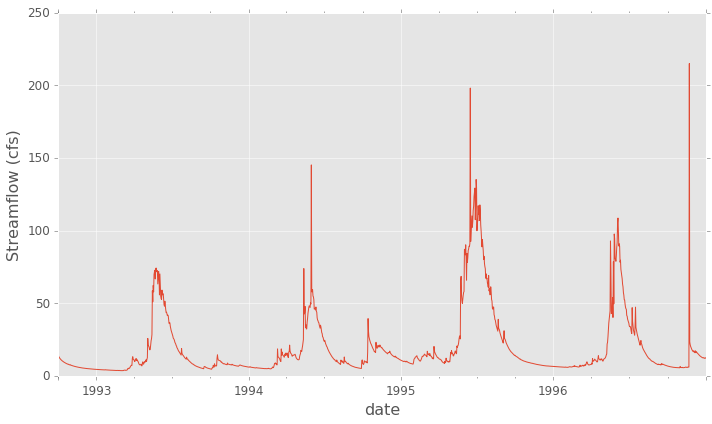

In [16]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', module='matplotlib')
warnings.filterwarnings('ignore', module='mpltools')

from mpltools import style
style.use('ggplot')

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['figure.dpi'] = 300.0
mpl.rcParams['xtick.labelsize'] = 12.0
mpl.rcParams['ytick.labelsize'] = 12.0
mpl.rcParams['axes.labelsize'] = 16.0
mpl.rcParams['axes.titlesize'] = 18.0
mpl.rcParams['legend.fontsize'] = 16.0

statvar_df.basin_cfs_1.plot()
plt.ylabel('Streamflow (cfs)')

Now let's load and plot the data file on top of the simulated streamflow from the statvar file.

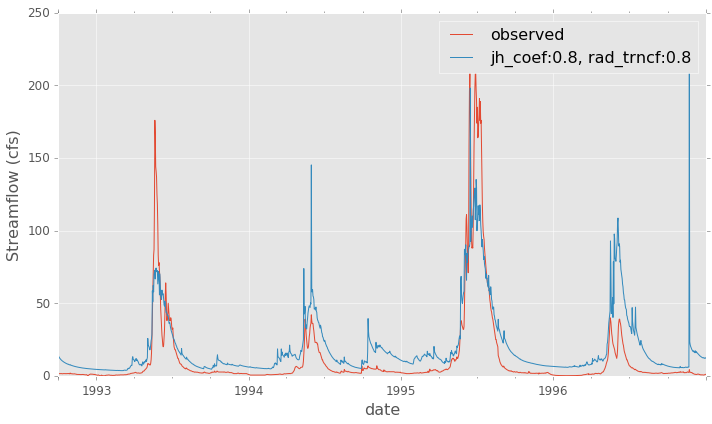

In [19]:
from prms_python import load_data_file

data_path = os.path.join(base_dir, 'data')
data_df = load_data_file(data_path)

data_df.runoff_1.plot(label='observed')
statvar_df.basin_cfs_1.plot(label=metadata['uuid_title_map'][ex_uuid].replace('"', '').replace('|',', '))

plt.ylabel('Streamflow (cfs)')
plt.legend()

## Calculate the Nash-Sutcliffe Model Efficiency for one Simulation

In parameterizing hydrological models, it's necesary to test multiple parameters and calculate the goodness-of-fit for each model run. Goodness-of-fit is a measure of how well the model output matches historical output so that future predictions may be made. A well-known GOF measure in Hydrology is the Nash-Sutcliffe model efficiency, from Nash & Sutcliffe's 1970 paper [River Flow Forecasting Through Conceptual Models Part I - A Discussion of Principles](./nash-sutcliffe-1970.pdf). They elegantly describe the model-fitting problem like so

> To remove subjectivity in fitting the model to the data or in determining the
parametric values, O'Donnell3) suggested automatic optimisation. This
involves successive changes of parameter values according to some pre-conceived
rule or pattern of increments which takes into account the results of
previous steps and in particular whether or not a change improved the fitting.  

The equation itself is

\begin{equation}
E = 1 - \frac{\sum_{t=1}^{T}\left(Q_o^t - Q_m^t\right)^2}{\sum_{t=1}^{T}\left(Q_o^t - \overline{Q_o}\right)^2}
\end{equation}

We have implemented this in the `prms_python/util.py` module. Below we import it and calculate it for the simulated hydrograph shown in the figure above.

Note that the closer to 1 the efficiency is, the more exactly the model accounts for observed variance. A value of 0 for efficiency means that the model does as well as the mean of the hydrograph for predictive purposes. A value below 0 means that the model does worse than the mean for modeling the hydrograph.

In [21]:
from prms_python import nash_sutcliffe

nash_sutcliffe(data_df.runoff_1, statvar_df.basin_cfs_1)

0.61349294467779569

## Calculate the Nash-Sutcliffe Efficiency for all Simulations

Now we'll iterate over all the statvar outputs and calculate the Nash-Sutcliffe model efficiency for each. To better understand the efficiency landscape across these two parameters, we'll use a matrix plot to see how the efficiency changes across scalings of each of the two parameters, `jh_coef` and `rad_trncf`.

In [25]:
idx_lookup = {'{:.1f}'.format(val): idx for idx, val in enumerate(np.arange(0.7, 1.0, 0.1))}
print idx_lookup

{'0.9': 2, '0.8': 1, '1.0': 3, '0.7': 0}


In [27]:
nash_sutcliffe_mat = np.zeros((4,4))

modeled_flows = {
    title: load_statvar(os.path.join('jupyternb-scenario-series-example', uu, 'outputs', 'statvar.dat')).basin_cfs_1
    for uu, title in metadata['uuid_title_map'].iteritems()
}
print modeled_flows.keys()[:5]

[u'"jh_coef":0.8|"rad_trncf":0.9', u'"jh_coef":1.0|"rad_trncf":0.7', u'"jh_coef":1.0|"rad_trncf":1.0', u'"jh_coef":0.9|"rad_trncf":0.9', u'"jh_coef":0.9|"rad_trncf":0.8']


In [30]:
observed = data_df.runoff_1

for title, hydrograph in modeled_flows.iteritems():
    param_scalings = eval('{' + title.replace('|', ',') + '}')
    coord = (idx_lookup[str(param_scalings['jh_coef'])], idx_lookup[str(param_scalings['rad_trncf'])])
    
    nash_sutcliffe_mat[coord] = nash_sutcliffe(observed, hydrograph)

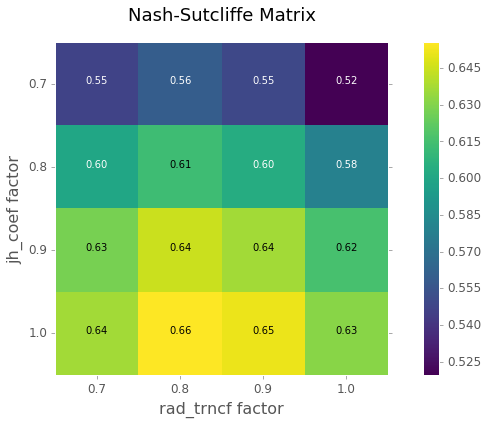

In [33]:
import itertools
fig, ax = plt.subplots()

cax = ax.matshow(nash_sutcliffe_mat, cmap='viridis')
tix = [0.7, 0.8, 0.9, 1.0]
plt.xticks(range(4), tix)
plt.yticks(range(4), tix)


ax.xaxis.set_ticks_position('bottom')
plt.ylabel('jh_coef factor')
plt.xlabel('rad_trncf factor')

for i, j in itertools.product(range(4), range(4)):
    plt.text(j, i, "%.2f" % nash_sutcliffe_mat[i, j],
             horizontalalignment="center", 
             color="w" if nash_sutcliffe_mat[i, j] < .61 else "k")

plt.title('Nash-Sutcliffe Matrix')
plt.grid(b=False)
cbar = fig.colorbar(cax)